In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
# загрузка и предобработка
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import string
!pip install -qq transformers
!pip install -qq datasets

from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AdamW, get_scheduler
# обучение
import torch
from torch.utils.data import DataLoader
# предобработка и финальный отчет по метрикам
from sklearn import preprocessing
from sklearn.metrics import classification_report
# прогресс бар
from tqdm import tqdm
# очистка кешей
import gc
# размер шрифта в графиках
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 31.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# создаем pandas datafraim
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/music_album_reviews.csv')

In [5]:
df.head()

,Review,Rating
0,i think i actually under-rate ok computer if a...,5.0
1,i get why radiohead rub a lot of people the wr...,5.0
2,i would like to think i am good about not lett...,4.5
3,there are radiohead devotees like there were o...,4.0
4,i wrote a shining excellent review for this al...,5.0


In [6]:
# данные несбалансированы
df['Rating'].value_counts()

Rating
5.0    29534
4.5    17793
4.0    14213
3.5     7048
3.0     4430
2.5     2210
2.0     1396
1.5      640
1.0      525
0.5      398
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80271 entries, 0 to 80270
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  80245 non-null  object 
 1   Rating  78187 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [8]:
df.isnull().sum()

Review      26
Rating    2084
dtype: int64

In [9]:
# предобработка данных, аугоментация текстов с рейтингом 0.5, 1.0, 1.5

In [10]:
df[df['Rating'] <= 2.0].isnull().sum()

Review    1
Rating    0
dtype: int64

In [11]:
df.isnull().value_counts()

Review  Rating
False   False     78162
        True       2083
True    False        25
        True          1
Name: count, dtype: int64

In [12]:
df1 = df.fillna(method='ffill')

In [13]:
df1.isnull().value_counts()

Review  Rating
False   False     80271
Name: count, dtype: int64

In [14]:

import re

def clean(inp: str) -> str:
    inp = inp.translate(str.maketrans(string.punctuation, " "*len(string.punctuation)))
    inp = re.sub(r'\s+', ' ', inp.lower())
    return inp

In [15]:
for text in df1['Review']:
    clean(text)


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80271 entries, 0 to 80270
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  80271 non-null  object 
 1   Rating  80271 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [17]:
df1.isnull().sum()

Review    0
Rating    0
dtype: int64

In [20]:
!pip install augmentex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 979.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 74.9 MB/s eta 0:00:00


In [21]:


from augmentex import WordAug

word_aug = WordAug(
    unit_prob=0.4, # Percentage of the phrase to which augmentations will be applied
    min_aug=1, # Minimum number of augmentations
    max_aug=4, # Maximum number of augmentations
    lang="eng", # supports: "rus", "eng"
    platform="pc", # supports: "pc", "mobile"
    random_seed=42,
    )

In [22]:
df_0_5 = df1[df1['Rating'] == 0.5].copy()

In [23]:
df_aug = pd.DataFrame(['Review'], ['Rating'])
df_aug

,0
Rating,Review


In [24]:
# убираю тексты с длинной меньше 4
df_0_5 = df_0_5.loc[df_0_5['Review'].str.len() > 3]

In [25]:
new_text_05 = []
for text in df_0_5['Review']:
    new_text_05.append(word_aug.augment(text=text, action="delete"))


In [26]:
df_aug_05 = pd.DataFrame(data=new_text_05, columns=['Review'])

In [27]:
df_aug_05['Rating'] = 0.5

In [28]:
len(df_aug_05['Rating']), len(df_aug_05['Review'])

(409, 409)

In [29]:
df_aug_05.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  409 non-null    object 
 1   Rating  409 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.5+ KB


In [30]:
# добавляю аугоментированные строки с рейтингом 0.5 в датафрейм
df1 = pd.concat([df1, df_aug_05]).reset_index().drop(columns='index')

In [31]:
df1.sample(frac=1).reset_index(drop=True)

,Review,Rating
0,this is like a 1960s cult-horror film put to m...,4.0
1,steely dans most jazzy work more jazz than roc...,5.0
2,blood on the tracks has been classified as dyl...,4.5
3,this album is not overrated. the reason you ke...,5.0
4,i like this album a lot. it goes from a blues ...,4.0
...,...,...
80675,no sei nem onde comear a falar deste cd. desde...,5.0
80676,despite all the sales records and histrionics ...,3.5
80677,a true masterpiece one of there best from ther...,5.0
80678,airbag - 4.5 paranoid android - 4.5 subterrane...,4.5


In [32]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80680 entries, 0 to 80679
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  80680 non-null  object 
 1   Rating  80680 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [33]:
###### аугоментация данных с рейтингом 1.0

In [34]:
df_1_0 = df1[df1['Rating'] == 1.0].copy()

In [35]:
df_aug_10 = pd.DataFrame(['Review'], ['Rating'])
df_aug_10

,0
Rating,Review


In [36]:
df_1_0['Review'].str.replace(r'[^\w\s]+', '')
new_text_10 = []
for text in df_1_0['Review']:
    new_text_10.append(word_aug.augment(text=text, action="reverse"))

df_aug_10 = pd.DataFrame(data=new_text_10, columns=['Review'])
df_aug_10['Rating'] = 1.0

In [37]:
len(df_aug_10['Rating']), len(df_aug_10['Review'])

(543, 543)

In [38]:
df_aug_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  543 non-null    object 
 1   Rating  543 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.6+ KB


In [39]:
df1 = pd.concat([df1, df_aug_10]).reset_index().drop(columns='index')

In [40]:
############## аугоментация текстов с рейтингом 1.5

In [41]:
df_1_5 = df1[df1['Rating'] == 1.5].copy()
df_aug_15 = pd.DataFrame(['Review'], ['Rating'])
df_1_5['Review'].str.replace(r'[^\w\s]+', '')
new_text_15 = []
for text in df_1_5['Review']:
    if len(text.split()) > 2:
        new_text_15.append(word_aug.augment(text=text, action="delete"))

df_aug_15 = pd.DataFrame(data=new_text_15, columns=['Review'])
df_aug_15['Rating'] = 1.5
len(df_aug_15['Rating']), len(df_aug_15['Review'])


(649, 649)

In [42]:
df_aug_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  649 non-null    object 
 1   Rating  649 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.3+ KB


In [43]:
#  добавляю измененные тексты в датафрейм
df1 = pd.concat([df1, df_aug_15]).reset_index().drop(columns='index')

In [44]:
df1.sample(frac=1).reset_index(drop=True)

,Review,Rating
0,although i have grown to enjoy this bands debu...,4.5
1,a brilliant and nearly flawless introduction t...,4.5
2,there are legions of them groups whose names a...,3.0
3,this is mount everest. if there is better musi...,5.0
4,boring repetetive songs few ideas that drag on...,1.5
...,...,...
81867,my favorites children of the damned the prison...,4.5
81868,. 2 . . acdc dee...,4.5
81869,another fantastic punk album although the prod...,3.5
81870,to say that ok computer is the best album of t...,5.0


In [45]:
df1.dropna(axis=0, inplace=True)

In [46]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81872 entries, 0 to 81871
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  81872 non-null  object 
 1   Rating  81872 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [47]:
df1['Review'][0], df['Rating'][0]

('i think i actually under-rate ok computer if anything. that is bonkers right? it is been my favourite album for over two decades now - but that right there is exactly the problem. i heard it when i was 15 and it was maybe the fourth or fifth album of any kind i would ever truly paid attention to front-to-back and the first that was not essentially forced upon me by my parents or general peer pressure at school. it was the first time i would ever decided it might be worth actually trying out music for real and the very first album i ever landed on just so happened to be the best one? nah. it is far too convenient. i keep side-eyeing it uneasily when i see it sitting at the top of my favourite albums list. surely the rush of hearing it now cannot be the same as it was when i was hearing it as a teenager. surely at least one of the 3500 albums i have heard since has surpassed it. right?! and yet i have been having this thought repeatedly for well over a decade now and every time i come 

In [48]:
df1['Review'].str.strip().str.lower()

0        i think i actually under-rate ok computer if a...
1        i get why radiohead rub a lot of people the wr...
2        i would like to think i am good about not lett...
3        there are radiohead devotees like there were o...
4        i wrote a shining excellent review for this al...
                               ...                        
81867    this is a bleak and album perhaps not bad but ...
81868    it is hard to go wrong with just straightforwa...
81869    i first checked this out in whole during my pi...
81870    when i first heard of this album i thought it ...
81871    this album just turns me off and am completely...
Name: Review, Length: 81872, dtype: object

In [49]:
df1['Review'].info(), df1['Rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 81872 entries, 0 to 81871
Series name: Review
Non-Null Count  Dtype 
--------------  ----- 
81872 non-null  object
dtypes: object(1)
memory usage: 639.8+ KB
<class 'pandas.core.series.Series'>
RangeIndex: 81872 entries, 0 to 81871
Series name: Rating
Non-Null Count  Dtype  
--------------  -----  
81872 non-null  float64
dtypes: float64(1)
memory usage: 639.8 KB


(None, None)

In [50]:
df1 = df1[['Review', 'Rating']]
df1.columns = ['text', 'labels']
df1.head()

,text,labels
0,i think i actually under-rate ok computer if a...,5.0
1,i get why radiohead rub a lot of people the wr...,5.0
2,i would like to think i am good about not lett...,4.5
3,there are radiohead devotees like there were o...,4.0
4,i wrote a shining excellent review for this al...,5.0


<Axes: >

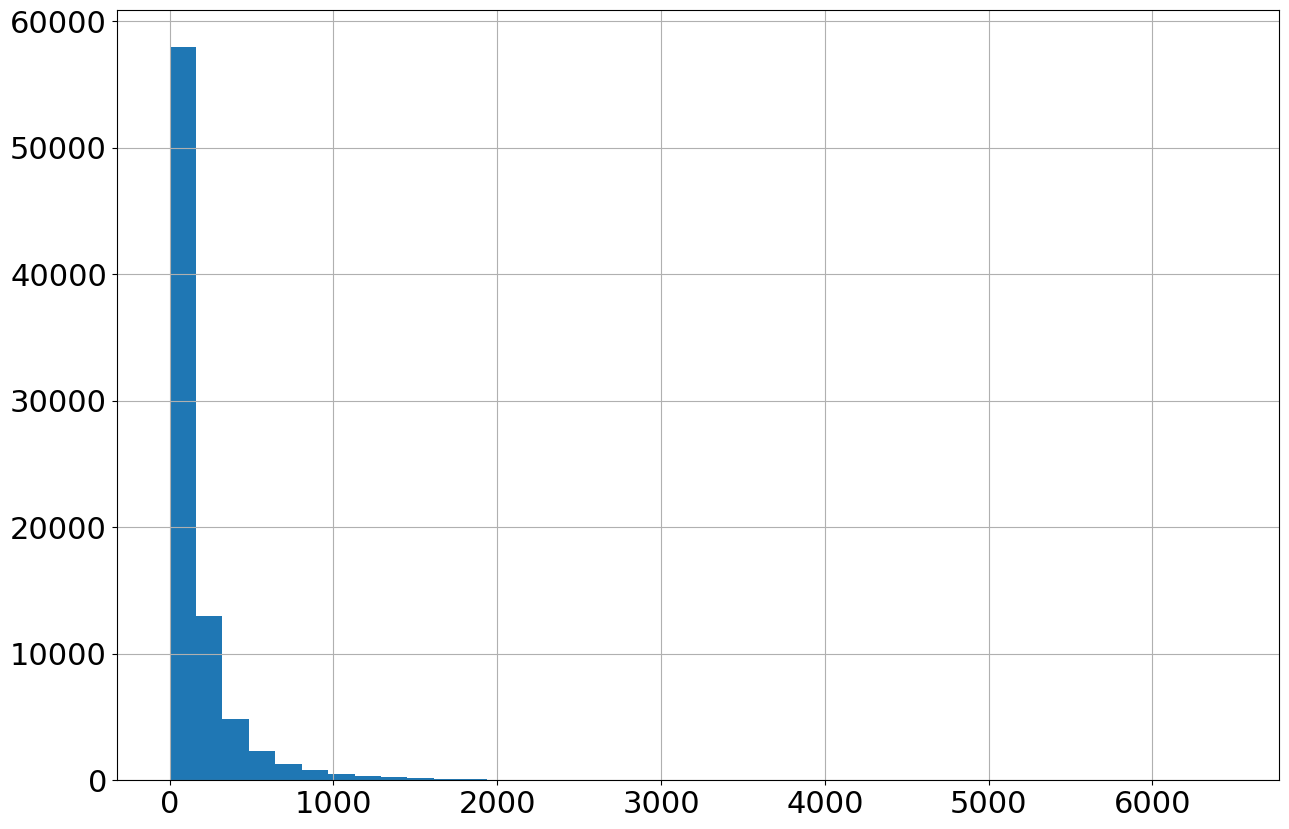

In [51]:
df1['text'].apply(lambda x: len(str(x).split())).hist(figsize=(15, 10), bins=40)

In [52]:
labels2num = {
    0.5: 0,
    1.0: 1,
    1.5: 2,
    2.0: 3,
    2.5: 4,
    3.0: 5,
    3.5: 6,
    4.0: 7,
    4.5: 8,
    5.0: 9,
}
labels2num = {k: int(v) for k, v in labels2num.items()}

num2labels = {
    0: 0.5,
    1: 1.0,
    2: 1.5,
    3: 2.0,
    4: 2.5,
    5: 3.0,
    6: 3.5,
    7: 4.0,
    8: 4.5,
    9: 5.0,
}
num2labels = {k: int(v) for k, v in num2labels.items()}

In [53]:
df1['labels'] = df1['labels'].map(labels2num)

In [54]:
df1.fillna(method='ffill')

,text,labels
0,i think i actually under-rate ok computer if a...,9
1,i get why radiohead rub a lot of people the wr...,9
2,i would like to think i am good about not lett...,8
3,there are radiohead devotees like there were o...,7
4,i wrote a shining excellent review for this al...,9
...,...,...
81867,this is a bleak and album perhaps not bad but ...,2
81868,it is hard to go wrong with just straightforwa...,2
81869,i first checked this out in whole during my pi...,2
81870,when i first heard of this album i thought it ...,2


In [ ]:
# df1.drop_duplicates()

In [55]:
print(df1['labels'])

0        9
1        9
2        8
3        7
4        9
        ..
81867    2
81868    2
81869    2
81870    2
81871    2
Name: labels, Length: 81872, dtype: int64


array([[<Axes: title={'center': 'labels'}>]], dtype=object)

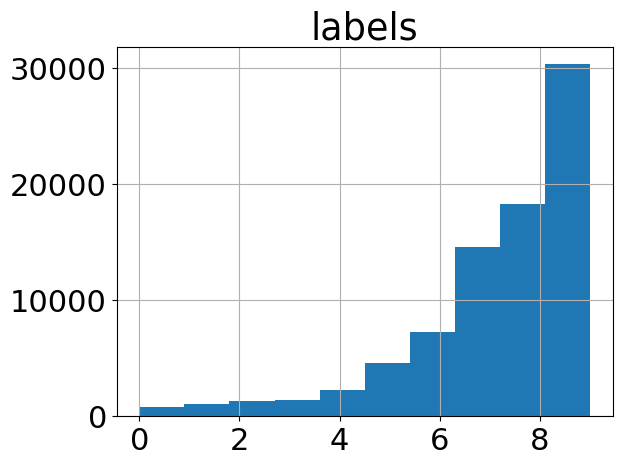

In [56]:
df1.hist('labels')

In [57]:
# оставляю датафрейм с текстами меньше 1500 слов
df1 = df1.loc[(df1['text'].str.len() > 3) & (df1['text'].str.len() < 1500)]

In [58]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68236 entries, 5 to 81871
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    68236 non-null  object
 1   labels  68236 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


In [59]:
print(df1['text'])

5        hurrah finally i had my first radiohead experi...
6        radiohead i nigel godrich wytworzyli prawdziwi...
7        so let me get this straight. a bunch of one-hi...
8        i can sort of understand the praise this album...
10       so yeah i decided highest rated on the site? g...
                               ...                        
81864    philip glass does not do it for me. is funny b...
81867    this is a bleak and album perhaps not bad but ...
81868    it is hard to go wrong with just straightforwa...
81869    i first checked this out in whole during my pi...
81871    this album just turns me off and am completely...
Name: text, Length: 68236, dtype: object


In [60]:
# перемешиваем и рабиваем на train test
df1 = df1.sample(frac=1).reset_index(drop=True)
train = df1[:int(len(df1)*0.85)]
test =  df1[int(len(df1)*0.85):]

In [61]:
len(train), len(test)

(58000, 10236)

In [62]:
print(len(train['labels'].value_counts()), len(test['labels'].value_counts()))
df1.info()

10 10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68236 entries, 0 to 68235
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    68236 non-null  object
 1   labels  68236 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [63]:
print(test['labels'].value_counts(), train['labels'].value_counts())
df1.info()

labels
9    3709
8    2252
7    1809
6     918
5     623
4     291
3     181
2     169
1     164
0     120
Name: count, dtype: int64 labels
9    21485
8    12618
7    10283
6     5193
5     3361
4     1662
3     1057
2      965
1      765
0      611
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68236 entries, 0 to 68235
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    68236 non-null  object
 1   labels  68236 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [64]:
print(train[train['labels'] == 0])

                                                    text  labels
5      i have listened to this album three times and ...       0
192    recipe for cooking yourself a cryptopsy-like d...       0
225    4.15??? oh my god. can a melomaniac enjoying a...       0
233     a favor and go listen to hendrix instead of this       0
259    i to listen to some of. my friends top 5s albu...       0
...                                                  ...     ...
57523  1 depressive depressive depressive...my ears b...       0
57759  crap. seriously total crap. if this is the bes...       0
57785  absurdooooooooooooo!!!! es inexplicable como e...       0
57865                                  listen to fugees.       0
57903  el disco que escucho cuando tengo mucho insomn...       0

[611 rows x 2 columns]


In [65]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [66]:
df1.isnull().sum()

text      0
labels    0
dtype: int64

In [67]:
model_name = "cointegrated/LaBSE-en-ru"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/521k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/516M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/LaBSE-en-ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
# подгружаю в модель веса полученные с предыдущих 2-х эпох и конфиг с измененным dropout на с 0.1 на 0.4
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/NLP/best_model_F1=0.4145_2epoch-20240519T082104Z-001/best_model_F1=0.4145_2epoch")

In [69]:
tokenizer

BertTokenizerFast(name_or_path='cointegrated/LaBSE-en-ru', vocab_size=55083, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [70]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(55083, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [71]:
names = list(model.named_parameters())
names[:3]

[('bert.embeddings.word_embeddings.weight',
  Parameter containing:
  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.1458,  0.1406, -0.0617,  ..., -0.0131, -0.0651,  0.0827],
          [-0.0005,  0.0164, -0.0240,  ..., -0.0217, -0.0244, -0.0542],
          ...,
          [-0.0846, -0.1349,  0.2057,  ...,  0.0686, -0.2711, -0.1173],
          [-0.0959,  0.0968, -0.0111,  ..., -0.0082, -0.0471,  0.0292],
          [-0.1986,  0.1389,  0.0213,  ...,  0.0607, -0.1313, -0.0792]],
         requires_grad=True)),
 ('bert.embeddings.position_embeddings.weight',
  Parameter containing:
  tensor([[-0.0766, -0.0023, -0.0312,  ...,  0.0336, -0.0083, -0.0431],
          [-0.0243,  0.0238, -0.0153,  ...,  0.0132,  0.0123,  0.0078],
          [-0.0177,  0.0114, -0.0234,  ..., -0.0429,  0.0074,  0.0058],
          ...,
          [-0.0204, -0.0186,  0.0021,  ..., -0.0401,  0.0139,  0.0067],
          [-0.0416, -0.0363,  0.0166,  ...,  0.0573,  0.0190, -0.0176],
      

In [72]:
torch.cuda.empty_cache()
import gc
gc.collect()

7

In [73]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [74]:
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [75]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 58000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 10236
    })
})

In [76]:
dataset = dataset.map(lambda e: tokenizer(e['text'], truncation = True, max_length=400, padding='max_length'), batched=True)

Map:   0%|          | 0/58000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10236 [00:00<?, ? examples/s]

In [77]:
# это стандартные колонки для формата пайторча, все кроме них убираем
pytorch_style_columns = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']  #
# убираем их из загрузчика
dataset = dataset.remove_columns(list(set(list(dataset['train'].features.keys())) - set(pytorch_style_columns)))

In [78]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 58000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10236
    })
})

In [79]:
dataset.set_format(type='torch', columns=pytorch_style_columns, device='cuda')

In [80]:
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=26)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=3)

In [81]:
len(train_dataloader)

2231

In [82]:
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [83]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [84]:
next(iter(train_dataloader))

{'labels': tensor([9, 8, 8, 2, 8, 8, 8, 9, 0, 9, 9, 9, 9, 9, 8, 6, 8, 7, 9, 9, 9, 9, 7, 6,
         5, 8], device='cuda:0'),
 'input_ids': tensor([[    2,   528, 12077,  ...,     0,     0,     0],
         [    2,  1248,   676,  ...,     0,     0,     0],
         [    2,  1945,   550,  ...,  1406,   980,     3],
         ...,
         [    2,  2235,   645,  ...,     0,     0,     0],
         [    2,   735,   545,  ...,     0,     0,     0],
         [    2,    77,  4097,  ...,     0,     0,     0]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
       

In [85]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(55083, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [86]:
from tqdm.auto import tqdm
from collections import deque


best_f1 = 0.
avg_loss = deque([], maxlen=30)

for epoch in range(num_epochs):
    print(40*'-', '\nepoch', epoch+1)
    model.train()
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for batch in tepoch:
            model.train()
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            avg_loss.append(loss.item())
            tepoch.set_postfix(loss=np.array(list(avg_loss)).mean())

    losses = []
    print('\nvalidating')
    f1 = load_metric('f1')
    acc = load_metric('accuracy')
    precision = load_metric('precision')
    recall = load_metric('recall')
    with torch.no_grad():
        model.eval()
        for batch in tqdm(test_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            f1.add_batch(predictions=predictions, references=batch["labels"])
            acc.add_batch(predictions=predictions, references=batch["labels"])
            precision.add_batch(predictions=predictions, references=batch["labels"])
            recall.add_batch(predictions=predictions, references=batch["labels"])
        print('weighted summary:')
        print('Test acc:', acc.compute()['accuracy'])
        print('Test precision:', precision.compute(average = 'macro')['precision'])
        print('Test recall:', recall.compute(average = 'macro')['recall'])
        f1_weighted = f1.compute(average = 'macro')['f1']
        print('Test f1:', f1_weighted, '\n')

        if f1_weighted > best_f1:
            best_f1 = f1_weighted
            model.save_pretrained(f"best_model_f1_max={best_f1}_len=511")
    # переводим обратно в режим тренировки для следующей эпохи
    model.train()

---------------------------------------- 
epoch 1


  0%|          | 0/2231 [00:00<?, ?batch/s]


validating


<ipython-input-86-0e0ee5d2aa50>:26: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  f1 = load_metric('f1')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/3412 [00:00<?, ?it/s]

weighted summary:
Test acc: 0.497557639703009
Test precision: 0.44919455943183245
Test recall: 0.32006691459579056
Test f1: 0.3568754059514163 



In [87]:
true = []
preds = []

model.eval()
for batch in tqdm(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    true += batch["labels"].detach().cpu().numpy().tolist()
    preds += predictions.detach().cpu().numpy().tolist()

  0%|          | 0/3412 [00:00<?, ?it/s]

In [ ]:
#true
#preds

In [88]:
labels2num = {
    0.5: 0,
    1.0: 1,
    1.5: 2,
    2.0: 3,
    2.5: 4,
    3.0: 5,
    3.5: 6,
    4.0: 7,
    4.5: 8,
    5.0: 9,
}
labels2num = {k: v for k, v in labels2num.items()}

num2labels = {
    0: 0.5,
    1: 1.0,
    2: 1.5,
    3: 2.0,
    4: 2.5,
    5: 3.0,
    6: 3.5,
    7: 4.0,
    8: 4.5,
    9: 5.0,
}
num2labels = {k: v for k, v in num2labels.items()}
num2labels

{0: 0.5,
 1: 1.0,
 2: 1.5,
 3: 2.0,
 4: 2.5,
 5: 3.0,
 6: 3.5,
 7: 4.0,
 8: 4.5,
 9: 5.0}

In [89]:
len(preds)

10236

In [90]:
from sklearn import preprocessing
from sklearn.metrics import classification_report

In [91]:
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.48      0.36      0.41       120
           1       0.99      0.49      0.66       164
           2       0.53      0.16      0.25       169
           3       0.18      0.06      0.09       181
           4       0.24      0.12      0.16       291
           5       0.32      0.22      0.26       623
           6       0.36      0.25      0.29       918
           7       0.39      0.32      0.35      1809
           8       0.37      0.39      0.38      2252
           9       0.63      0.83      0.71      3709

    accuracy                           0.50     10236
   macro avg       0.45      0.32      0.36     10236
weighted avg       0.47      0.50      0.47     10236



In [ ]:
print(classification_report(true, preds))